# Size, Book to Market, Momentum Benchmarks (Python)

<p class="lead">This script replicates the characteristic-based benchmarks of Daniel, Grinblatt, Titman, and Wermers (JF, 1997). These benchmarks are widely used today for mutual fund performance evaluation tests that make use of mutual fund portfolio holdings.</p>

## Background
The Daniel, Grinblatt, Titman, and Wermers (1997) benchmarks allow each U.S. equity to be precisely risk-adjusted for its size, book-to-market, and momentum characteristics during short time-periods, such as days, weeks, or months. This benchmarking approach allows a much more precise determination of the performance of a portfolio of stocks during a short (or long) time-period than convention regression tests, as argued in DGTW (1997). As such, it is applicable to a wide variety of situations, including corporate event studies and tests of the efficiency of stock markets, as well as the more traditional tests of the performance of asset managers.

## Characteristic-Based Benchmarks
The script below replicates the characteristic-based benchmarks of Daniel, Grinblatt, Titman, and Wermers (JF, 1997). These benchmarks are widely used today for mutual fund performance evaluation tests that make use of mutual fund portfolio holdings. The end-result of the script is the assignment of each stock to one of 125 portfolios of securities that share similar size, book to market, and momentum characteristics. Together with the benchmark assignment, the monthly return of each stock is provided along with the associated benchmark returns.

The program follows the same methodology as in DGTW (1997), with the only difference being that the book to market ratios are adjusted for industries using the 48 Fama and French industry classifications available at French's website. Note that the benchmarks provided by Wermers result from a different industry adjustment of book to market ratios. For more information on how Wermers' industry adjustment is done, check the benchmark return website.

In [ ]:
##########################################
# Characteristics-Based Benchmarks       #
# Sep 2019                               #
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats

###################
# Connect to WRDS #
###################
conn=wrds.Connection()

###################
# CRSP Block      #
###################
# sql similar to crspmerge macro

crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, b.ncusip, a.date, 
                      b.shrcd, b.exchcd, b.siccd,
                      a.ret, a.vol, a.shrout, a.prc, a.cfacpr, a.cfacshr
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1970' and '12/31/2017'
                      and b.shrcd between 10 and 11
                      """) 

# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=\
    crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['date']=pd.to_datetime(crsp_m['date'])
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)
crsp_m['p']=crsp_m['prc'].abs()/crsp_m['cfacpr'] # price adjusted
crsp_m['tso']=crsp_m['shrout']*crsp_m['cfacshr']*1e3 # total shares out adjusted
crsp_m['me'] = crsp_m['p']*crsp_m['tso']/1e6 # market cap in $mil

# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp_m.groupby(['jdate','permco'])['me'].sum().reset_index()\
    .rename(columns={'me':'me_comp'})
crsp_m=pd.merge(crsp_m, crsp_summe, how='inner', on=['jdate','permco'])


###################
# Compustat Block #
###################

comp = conn.raw_sql("""
                    select gvkey, datadate, cusip, 
                    sich, seq, pstkrv, pstkl, pstk, txdb, itcb
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1970'
                    """)

comp['datadate']=pd.to_datetime(comp['datadate']) #convert datadate to date fmt
comp['year']=comp['datadate'].dt.year

comp = comp[comp['seq']>0]

# create preferrerd stock:
# 1st choice: Preferred stock - Redemption Value
# 2nd choice: Preferred stock - Liquidating Value
# 3rd choice: Preferred stock - Carrying Value, Stock (Capital) - Total
comp['pref']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['pref']=np.where(comp['pref'].isnull(),comp['pstk'], comp['pref'])
comp['pref']=np.where(comp['pref'].isnull(),0,comp['pref'])

# fill in missing values for deferred taxes and investment tax credit
comp['txdb']=comp['txdb'].fillna(0)
comp['itcb']=comp['itcb'].fillna(0)

# create book equity
# Daniel and Titman (JF 1997):    
# BE = stockholders' equity + deferred taxes + investment tax credit - Preferred Stock
comp['be']=comp['seq']+comp['txdb']+comp['itcb']-comp['pref']

# keep only records with non-negative book equity
comp = comp[comp['be']>=0]
comp=comp[['gvkey','datadate','year','be','sich']]


#########################
# Add Historical PERMCO #
#########################
ccm=conn.raw_sql("""
                  select gvkey, lpermco as permco, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where (linktype ='LU' or linktype='LC')
                  """)

ccm['linkdt']=pd.to_datetime(ccm['linkdt'])
ccm['linkenddt']=pd.to_datetime(ccm['linkenddt'])
# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

ccm1=pd.merge(comp,ccm,how='left',on=['gvkey'])
ccm1['jdate']=ccm1['datadate']+MonthEnd(0)
ccm1['year']=ccm1.datadate.dt.year

# set link date bounds
comp2=ccm1[(ccm1['datadate']>=ccm1['linkdt'])&(ccm1['datadate']<=ccm1['linkenddt'])]
comp2=comp2[['gvkey','permco','datadate', 'year','jdate', 'be', 'sich', 'linkprim']]


# link comp and crsp to calculate book-to-market ratio each fiscal year end
comp3=pd.merge(comp2, crsp_m[['permno','permco','date','jdate','siccd','me','me_comp']],\
               how='inner', on=['permco', 'jdate'])
comp3['bm']=comp3['be'].div(comp3['me_comp'])

comp3 = comp3.sort_values(['permno', 'year', 'datadate', 'linkprim', 'bm'])\
    .drop_duplicates()

# pick max datadate for a given permno year combo (firm changes fiscal period)
maxdatadate=comp3.groupby(['permno','year'])['datadate'].max()\
    .reset_index()

comp3 = pd.merge(comp3, maxdatadate, how='inner', on=['permno','year','datadate'])

#########################
# Assign Fama-French 48 #
#########################

# function to assign ffi48 classification
def ffi48(row):
    if (100<=row['sic'] <=299) or (700<=row['sic']<=799) or (910<=row['sic']<=919) or (row['sic']==2048):
        ffi48=1
        ffi48_desc='Agric'
    elif (2000<=row['sic']<=2046) or (2050<=row['sic']<=2063) or (2070<=row['sic']<=2079)\
    or (2090<=row['sic']<=2092) or (row['sic']==2095) or (2098<=row['sic']<=2099):
        ffi48=2
        ffi48_desc='Food'
    elif (2064<=row['sic']<=2068) or (2086<=row['sic']<=2087) or (2096<=row['sic']<=2097):
        ffi48=3
        ffi48_desc='Soda'
    elif (row['sic']==2080) or (2082<=row['sic']<=2085):
        ffi48=4
        ffi48_desc='Beer'
    elif (2100<=row['sic']<=2199):
        ffi48=5
        ffi48_desc='Smoke'
    elif (920<=row['sic']<=999) or (3650<=row['sic']<=3652) or (row['sic']==3732) or (3930<=row['sic']<=3931) or (3940<=row['sic']<=3949):
        ffi48=6
        ffi48_desc='Toys'
    elif (7800<=row['sic']<=7833) or (7840<=row['sic']<=7841) or(row['sic']==7900)or (7910<=row['sic']<=7911) or (7920<=row['sic']<=7933)\
    or (7940<=row['sic']<=7949) or (row['sic']==7980) or (7990<=row['sic']<=7999):
        ffi48=7
        ffi48_desc='Fun'
    elif (2700<=row['sic']<=2749) or (2770<=row['sic']<=2771) or (2780<=row['sic']<=2799):
        ffi48=8
        ffi48_desc='Books'
    elif (row['sic']==2047) or (2391<=row['sic']<=2392) or (2510<=row['sic']<=2519) or (2590<=row['sic']<=2599) or (2840<=row['sic']<=2844)\
    or (3160<=row['sic']<=3161) or (3170<=row['sic']<=3172) or (3190<=row['sic']<=3199) or (row['sic']==3229) or (row['sic']==3260)\
    or (3262<=row['sic']<=3263) or (row['sic']==3269) or (3230<=row['sic']<=3231) or(3630<=row['sic']<=3639) or (3750<=row['sic']<=3751)\
    or (row['sic']==3800) or (3860<=row['sic']<=3861) or (3870<=row['sic']<=3873) or (3910<=row['sic']<=3911) or (3914<=row['sic']<=3915)\
    or (3960<=row['sic']<=3962) or (row['sic']==3991) or (row['sic']==3995):
        ffi48=9
        ffi48_desc='Hshld'
    elif (2300<=row['sic']<=2390) or (3020<=row['sic']<=3021) or (3100<=row['sic']<=3111)\
    or (3130<=row['sic']<=3131) or (3140<=row['sic']<=3151) or (3963<=row['sic']<=3965):
        ffi48=10
        ffi48_desc='Clths'
    elif (8000<=row['sic']<=8099):
        ffi48=11
        ffi48_desc='Hlth'
    elif (row['sic']==3693) or (3840<=row['sic']<=3851):
        ffi48=12
        ffi48_desc='MedEq'
    elif (2830<=row['sic']<=2831) or (2833<=row['sic']<=2836):
        ffi48=13
        ffi48_desc='Drugs'
    elif (2800<=row['sic']<=2829) or (2850<=row['sic']<=2879) or (2890<=row['sic']<=2899):
        ffi48=14
        ffi48_desc='Chems'
    elif (row['sic']==3031) or (row['sic']==3041) or (3050<=row['sic']<=3053) or (3060<=row['sic']<=3069) or (3070<=row['sic']<=3099):
        ffi48=15
        ffi48_desc='Rubbr'
    elif (2200<=row['sic']<=2284) or (2290<=row['sic']<=2295) or (2297<=row['sic']<=2299) or (2393<=row['sic']<=2395) or (2397<=row['sic']<=2399):
        ffi48=16
        ffi48_desc='Txtls'
    elif (800<=row['sic']<=899) or (2400<=row['sic']<=2439) or (2450<=row['sic']<=2459) or (2490<=row['sic']<=2499) or (2660<=row['sic']<=2661)\
    or (2950<=row['sic']<=2952) or (row['sic']==3200) or (3210<=row['sic']<=3211) or (3240<=row['sic']<=3241) or (3250<=row['sic']<=3259)\
    or (row['sic']==3261) or (row['sic']==3264) or (3270<=row['sic']<=3275) or (3280<=row['sic']<=3281) or (3290<=row['sic']<=3293)\
    or (3295<=row['sic']<=3299) or (3420<=row['sic']<=3433) or (3440<=row['sic']<=3442) or (row['sic']==3446) or (3448<=row['sic']<=3452)\
    or (3490<=row['sic']<=3499) or (row['sic']==3996):
        ffi48=17
        ffi48_desc='BldMt'
    elif (1500<=row['sic']<=1511) or (1520<=row['sic']<=1549) or (1600<=row['sic']<=1799):
        ffi48=18
        ffi48_desc='Cnstr'
    elif (row['sic']==3300) or (3310<=row['sic']<=3317) or (3320<=row['sic']<=3325) or (3330<=row['sic']<=3341) or(3350<=row['sic']<=3357)\
    or (3360<=row['sic']<=3379) or (3390<=row['sic']<=3399):
        ffi48=19
        ffi48_desc='Steel'
    elif (row['sic']==3400) or (3443<=row['sic']<=3444) or (3460<=row['sic']<=3479):
        ffi48=20
        ffi48_desc='FabPr'
    elif (3510<=row['sic']<=3536) or (row['sic']==3538) or (3540<=row['sic']<=3569)\
    or (3580<=row['sic']<=3582) or (3585<=row['sic']<=3586) or (3589<=row['sic']<=3599):
        ffi48=21
        ffi48_desc='Mach'
    elif (row['sic']==3600) or (3610<=row['sic']<=3613) or (3620<=row['sic']<=3621) or (3623<=row['sic']<=3629) or (3640<=row['sic']<=3646)\
    or (3648<=row['sic']<=3649) or (row['sic']==3660) or (3690<=row['sic']<=3692) or (row['sic']==3699):
            ffi48=22
            ffi48_desc='ElcEq'
    elif (row['sic']==2296) or (row['sic']==2396) or (3010<=row['sic']<=3011) or (row['sic']==3537) or (row['sic']==3647) or (row['sic']==3694)\
    or (row['sic']==3700) or (3710<=row['sic']<=3711) or (3713<=row['sic']<=3716) or (3790<=row['sic']<=3792) or (row['sic']==3799):
        ffi48=23
        ffi48_desc='Autos'
    elif (3720<=row['sic']<=3721) or (3723<=row['sic']<=3725) or (3728<=row['sic']<=3729):
        ffi48=24
        ffi48_desc='Aero'
    elif (3730<=row['sic']<=3731) or (3740<=row['sic']<=3743):
        ffi48=25
        ffi48_desc='Ships'
    elif (3760<=row['sic']<=3769) or (row['sic']==3795) or (3480<=row['sic']<=3489):
        ffi48=26
        ffi48_desc='Guns'
    elif (1040<=row['sic']<=1049):
        ffi48=27
        ffi48_desc='Gold'
    elif (1000<=row['sic']<=1039) or (1050<=row['sic']<=1119) or (1400<=row['sic']<=1499):
        ffi48=28
        ffi48_desc='Mines'
    elif (1200<=row['sic']<=1299):
        ffi48=29
        ffi48_desc='Coal'
    elif (row['sic']==1300) or (1310<=row['sic']<=1339) or (1370<=row['sic']<=1382) or (row['sic']==1389) or (2900<=row['sic']<=2912) or (2990<=row['sic']<=2999):
        ffi48=30
        ffi48_desc='Oil'
    elif (row['sic']==4900) or (4910<=row['sic']<=4911) or (4920<=row['sic']<=4925) or (4930<=row['sic']<=4932) or (4939<=row['sic']<=4942):
        ffi48=31
        ffi48_desc='Util'
    elif (row['sic']==4800) or (4810<=row['sic']<=4813) or (4820<=row['sic']<=4822) or (4830<=row['sic']<=4841) or (4880<=row['sic']<=4892) or (row['sic']==4899):
        ffi48=32
        ffi48_desc='Telcm'
    elif (7020<=row['sic']<=7021) or (7030<=row['sic']<=7033) or (row['sic']==7200) or (7210<=row['sic']<=7212) or (7214<=row['sic']<=7217)\
    or (7219<=row['sic']<=7221) or (7230<=row['sic']<=7231) or (7240<=row['sic']<=7241) or (7250<=row['sic']<=7251) or (7260<=row['sic']<=7299)\
    or (row['sic']==7395) or (row['sic']==7500) or (7520<=row['sic']<=7549) or (row['sic']==7600) or (row['sic']==7620)\
    or (7622<=row['sic']<=7623) or (7629<=row['sic']<=7631) or (7640<=row['sic']<=7641) or (7690<=row['sic']<=7699) or (8100<=row['sic']<=8499)\
    or (8600<=row['sic']<=8699) or (8800<=row['sic']<=8899) or (7510<=row['sic']<=7515):
        ffi48=33
        ffi48_desc='PerSv'
    elif (2750<=row['sic']<=2759) or (row['sic']==3993) or (row['sic']==7218) or (row['sic']==7300) or (7310<=row['sic']<=7342)\
    or (7349<=row['sic']<=7353) or (7359<=row['sic']<=7372) or (7374<=row['sic']<=7385) or (7389<=row['sic']<=7394) or (7396<=row['sic']<=7397)\
    or (row['sic']==7399) or (row['sic']==7519) or (row['sic']==8700) or (8710<=row['sic']<=8713) or (8720<=row['sic']<=8721) \
    or (8730<=row['sic']<=8734) or (8740<=row['sic']<=8748) or (8900<=row['sic']<=8911) or (8920<=row['sic']<=8999) or (4220<=row['sic']<=4229):
        ffi48=34
        ffi48_desc='BusSv'
    elif (3570<=row['sic']<=3579) or (3680<=row['sic']<=3689) or (row['sic']==3695) or (row['sic']==7373):
        ffi48=35
        ffi48_desc='Comps'
    elif (row['sic']==3622) or (3661<=row['sic']<=3666) or (3669<=row['sic']<=3679) or (row['sic']==3810) or (row['sic']==3812):
        ffi48=36
        ffi48_desc='Chips'
    elif (row['sic']==3811) or (3820<=row['sic']<=3827) or (3829<=row['sic']<=3839):
        ffi48=37
        ffi48_desc='LabEq'
    elif (2520<=row['sic']<=2549) or (2600<=row['sic']<=2639) or (2670<=row['sic']<=2699) or (2760<=row['sic']<=2761) or (3950<=row['sic']<=3955):
        ffi48=38
        ffi48_desc='Paper'
    elif (2440<=row['sic']<=2449) or (2640<=row['sic']<=2659) or (3220<=row['sic']<=3221) or (3410<=row['sic']<=3412):
        ffi48=39
        ffi48_desc='Boxes'
    elif (4000<=row['sic']<=4013) or (4040<=row['sic']<=4049) or (row['sic']==4100)  or (4110<=row['sic']<=4121) or (4130<=row['sic']<=4131)\
    or (4140<=row['sic']<=4142) or (4150<=row['sic']<=4151) or (4170<=row['sic']<=4173) or (4190<=row['sic']<=4200)\
    or (4210<=row['sic']<=4219) or (4230<=row['sic']<=4231) or (4240<=row['sic']<=4249) or (4400<=row['sic']<=4700) or (4710<=row['sic']<=4712)\
    or (4720<=row['sic']<=4749) or (row['sic']==4780) or (4782<=row['sic']<=4785) or (row['sic']==4789):
        ffi48=40
        ffi48_desc='Trans'
    elif (row['sic']==5000) or (5010<=row['sic']<=5015) or (5020<=row['sic']<=5023) or (5030<=row['sic']<=5060) or (5063<=row['sic']<=5065)\
    or (5070<=row['sic']<=5078) or (5080<=row['sic']<=5088) or (5090<=row['sic']<=5094) or (5099<=row['sic']<=5100)\
    or (5110<=row['sic']<=5113) or (5120<=row['sic']<=5122) or (5130<=row['sic']<=5172) or (5180<=row['sic']<=5182) or (5190<=row['sic']<=5199):
        ffi48=41
        ffi48_desc='Whlsl'
    elif (row['sic']==5200) or (5210<=row['sic']<=5231) or (5250<=row['sic']<=5251) or (5260<=row['sic']<=5261) or (5270<=row['sic']<=5271)\
    or (row['sic']==5300) or (5310<=row['sic']<=5311) or (row['sic']==5320) or (5330<=row['sic']<=5331) or (row['sic']==5334)\
    or (5340<=row['sic']<=5349) or (5390<=row['sic']<=5400) or (5410<=row['sic']<=5412) or (5420<=row['sic']<=5469) or (5490<=row['sic']<=5500)\
    or (5510<=row['sic']<=5579) or (5590<=row['sic']<=5700) or (5710<=row['sic']<=5722) or (5730<=row['sic']<=5736) or (5750<=row['sic']<=5799)\
    or (row['sic']==5900) or (5910<=row['sic']<=5912) or (5920<=row['sic']<=5932) or (5940<=row['sic']<=5990) or (5992<=row['sic']<=5995) or (row['sic']==5999):
        ffi48=42
        ffi48_desc='Rtail'
    elif (5800<=row['sic']<=5829) or (5890<=row['sic']<=5899) or (row['sic']==7000) or (7010<=row['sic']<=7019) or (7040<=row['sic']<=7049) or (row['sic']==7213):
        ffi48=43
        ffi48_desc='Meals'
    elif (row['sic']==6000) or (6010<=row['sic']<=6036) or (6040<=row['sic']<=6062) or (6080<=row['sic']<=6082) or (6090<=row['sic']<=6100)\
    or (6110<=row['sic']<=6113) or (6120<=row['sic']<=6179) or (6190<=row['sic']<=6199):
        ffi48=44
        ffi48_desc='Banks'
    elif (row['sic']==6300) or (6310<=row['sic']<=6331) or (6350<=row['sic']<=6351) or (6360<=row['sic']<=6361) or (6370<=row['sic']<=6379) or (6390<=row['sic']<=6411):
        ffi48=45
        ffi48_desc='Insur'
    elif (row['sic']==6500) or (row['sic']==6510) or (6512<=row['sic']<=6515) or (6517<=row['sic']<=6532) or (6540<=row['sic']<=6541)\
    or (6550<=row['sic']<=6553) or (6590<=row['sic']<=6599) or (6610<=row['sic']<=6611):
        ffi48=46
        ffi48_desc='RlEst'
    elif (6200<=row['sic']<=6299) or (row['sic']==6700) or (6710<=row['sic']<=6726) or (6730<=row['sic']<=6733) or (6740<=row['sic']<=6779)\
    or (6790<=row['sic']<=6795) or (6798<=row['sic']<=6799):
        ffi48=47
        ffi48_desc='Fin'
    elif (4950<=row['sic']<=4961) or (4970<=row['sic']<=4971) or (4990<=row['sic']<=4991) or (row['sic']==9999):
        ffi48=48
        ffi48_desc='Other'
    else:
        ffi48=np.nan
        ffi48_desc=''
    return pd.Series({'sic': row['sic'], 'ffi48': ffi48, 'ffi48_desc': ffi48_desc})

# assign SIC code
comp4 = comp3
# First use historical Compustat SIC Code
# Then if missing use historical CRSP SIC Code
comp4['sic']=np.where(comp4['sich']>0, comp4['sich'], comp4['siccd'])

# and adjust some SIC code to fit F&F 48 ind delineation
comp4['sic']=np.where((comp4['sic'].isin([3990, 9995, 9997])) & (comp4['siccd']>0) & (comp4['sic'] != comp4['siccd']), \
             comp4['siccd'], comp4['sic'])
comp4['sic']=np.where(comp4['sic'].isin([3990,3999]), 3991, comp4['sic'])
comp4['sic']=comp4.sic.astype(int)

# assign the ffi48 function to comp4
_sic = comp4['sic'].unique()
_sicff = pd.DataFrame(_sic).rename(columns={0:'sic'})
_sicff = _sicff.apply(ffi48, axis=1)
comp4 = pd.merge(comp4, _sicff, how='left', on=['sic'])

# keep only records with non-missing bm and ffi48 classification
comp4 = comp4[(comp4['bm'] != np.NaN) & (comp4['ffi48_desc'] !='')] 
comp4 = comp4.drop(['sich','siccd','datadate'], axis=1)
comp4=comp4.sort_values(['ffi48','year'])


#########################
# Industry BM Average   #
#########################

# Calculate BM Industry Average Each Period
comp4_tmp = comp4[(comp4['ffi48']>0)&(comp4['bm']>=0)]
bm_ind = comp4_tmp.groupby(['ffi48','year'])['bm'].mean().reset_index().rename(columns={'bm':'bmind'})

# Calculate Long-Term Industry BtM Average
bm_ind['n'] = bm_ind.groupby(['ffi48'])['year'].cumcount()
bm_ind['sumbm']=bm_ind.groupby(['ffi48'])['bmind'].cumsum()
bm_ind['bmavg'] = bm_ind['sumbm']/(bm_ind['n']+1)
bm_ind = bm_ind.drop(['n','sumbm'], axis=1)

# Adjust Firm-Specific BtM with Industry Averages
comp5 = pd.merge(comp4, bm_ind, how='left',on=['ffi48','year'])
comp5['bm_adj'] = comp5['bm']-comp5['bmavg']


#########################
# Momentum Factor       #
#########################

# Create (12,1) Momentum Factor with at least 6 months of returns
_tmp_crsp = crsp_m[['permno','date','ret', 'me', 'exchcd']].sort_values(['permno','date']).set_index('date')
#replace missing return with 0
_tmp_crsp['ret']=_tmp_crsp['ret'].fillna(0)
_tmp_crsp['logret']=np.log(1+_tmp_crsp['ret'])
_tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(12, min_periods=7).sum()
_tmp_cumret = _tmp_cumret.reset_index()
_tmp_cumret['cumret']=np.exp(_tmp_cumret['logret'])-1

sizemom = pd.merge(_tmp_crsp.reset_index(), _tmp_cumret[['permno','date','cumret']], how='left', on=['permno','date'])
sizemom['mom']=sizemom.groupby('permno')['cumret'].shift(1)
sizemom=sizemom[sizemom['date'].dt.month==6].drop(['logret','cumret'], axis=1).rename(columns={'me':'size'})


#########################
# NYSE Size Breakpoint  #
#########################

# Get Size Breakpoints for NYSE firms
sizemom=sizemom.sort_values(['date','permno']).drop_duplicates()
nyse = sizemom[sizemom['exchcd']==1]
nyse_break = nyse.groupby(['date'])['size'].describe(percentiles=[.2,.4,.6,.8]).reset_index()
nyse_break = nyse_break[['date','20%','40%','60%','80%']]\
.rename(columns={'20%':'dec20', '40%':'dec40', '60%':'dec60','80%':'dec80'})

sizemom = pd.merge(sizemom, nyse_break, how='left', on='date')

# Add NYSE Size Breakpoints to the Data
def size_group(row):
    if 0<=row['size'] < row['dec20']:
        value = 1
    elif row['size'] < row['dec40']:
        value=2
    elif row['size'] < row['dec60']:
        value=3
    elif row['size'] < row['dec80']:
        value=4
    elif row['size'] >= row['dec80']:
        value=5
    else:
        value=np.nan
    return value

sizemom['group']=sizemom.apply(size_group, axis=1)
sizemom['year']=sizemom['date'].dt.year-1
sizemom=sizemom[['permno','date','year','mom','group','size','ret']]

# Adjusted BtM from the calendar year preceding the formation date
comp6=comp5[['gvkey','permno','year','bm_adj']]
comp6=pd.merge(comp6, sizemom, how='inner', on=['permno','year'])
comp6=comp6.dropna(subset=['size','mom','bm_adj','ret'], how='any')

#########################
# Size BM MOM Portfolio #
#########################

# Start the Triple Sort on Size, Book-to-Market, and Momentum
port1=comp6.sort_values(['date','group','permno']).drop_duplicates()
port1['bmr']=port1.groupby(['date','group'])['bm_adj'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))
port2 = port1.sort_values(['date','group','bmr'])
port2['momr']=port2.groupby(['date','group','bmr'])['mom'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))

# DGTW_PORT 1 for Bottom Quintile, 5 for Top Quintile
port3=port2
port3['bmr']=port3['bmr']+1
port3['momr']=port3['momr']+1
port3[['group','bmr','momr']]=port3[['group','bmr','momr']].astype(int).astype(str)
port3['dgtw_port']=port3['group']+port3['bmr']+port3['momr']
port4 = port3[['permno','gvkey','date','size','mom','bm_adj','dgtw_port']]
port4['date']=port4['date']+MonthEnd(0)
port4['jyear']=port4['date'].dt.year
port4=port4.sort_values(['permno','date'])
port4=port4.rename(columns={'date':'formdate', 'size':'sizew'})
port4=port4[['permno','formdate','jyear','sizew','dgtw_port']]

crsp_m1= crsp_m[['permno','date','ret']]
crsp_m1['date']=crsp_m1['date']+MonthEnd(0)
crsp_m1['jdate']=crsp_m1['date']+MonthEnd(-6)
crsp_m1['jyear']=crsp_m1['jdate'].dt.year

crsp_m1 = pd.merge(crsp_m1.drop(['jdate'],axis=1), port4, how='left', on=['permno','jyear'])
crsp_m1 = crsp_m1.dropna(subset=['formdate','sizew','dgtw_port'], how='any')

crsp_m1 = crsp_m1.sort_values(['date','dgtw_port','permno'])

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan
# Calculate Weighted Average Returns    
dgtw_vwret = crsp_m1.groupby(['date','dgtw_port']).apply(wavg, 'ret','sizew')
dgtw_vwret = dgtw_vwret.reset_index().rename(columns={0:'dgtw_vwret'})

# Calculate DGTW Excess Return
dgtw_returns = pd.merge(crsp_m1.drop(['sizew'], axis=1), dgtw_vwret, how='left', on =['dgtw_port','date'])
dgtw_returns['dgtw_xret']=dgtw_returns['ret']-dgtw_returns['dgtw_vwret']
dgtw_returns = dgtw_returns.sort_values(['permno','date']).drop_duplicates()

## Outcome Discussion
The DGTW portfolio is ordered by Size, Book-to-Market and Momentum. The blue solid line represents the value-weighted portfolio return of Size=1, Book-to-Market=1 and Momentum=1 (dgtw_vwret[dgtw_vwret.dgtw_port=='111'].dgtw_vwret), and the red dash line represents the value-weighted portfolio return of Size=5, Book-to-Market=1 and Momentum=5 (dgtw_vwret[dgtw_vwret.dgtw_port=='515'].dgtw_vwret)

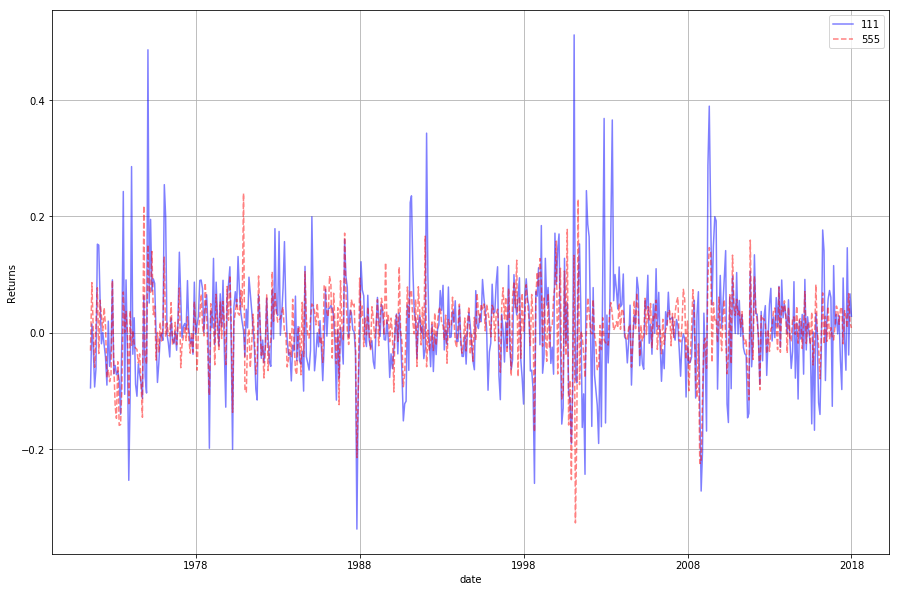

In [6]:
plt.figure(figsize=(15,10))
plt.plot(dgtw_vwret[dgtw_vwret.dgtw_port=='111'].date, dgtw_vwret[dgtw_vwret.dgtw_port=='111'].dgtw_vwret, 'b', alpha=0.5)
plt.plot(dgtw_vwret[dgtw_vwret.dgtw_port=='515'].date, dgtw_vwret[dgtw_vwret.dgtw_port=='515'].dgtw_vwret, 'r--', alpha=0.5)
plt.xlabel('date')
plt.ylabel('Returns')
plt.legend(['111', '555'])
plt.grid(True)

## References
Alexander, Gordon, Gjergji Cici, and Scott Gibson, 2006, "Does Motivation Matter When Assessing Trade Performance” An Analysis of Mutual Funds," Review of Financial Studies, Vol. 20, No. 1, 125-150.

Chen, Hsiu-Lang, Narasimhan Jegadeesh, and Russ Wermers, 2000, “The Value of Active Mutual Fund Management: An examination of the Stockholdings and Trades of Fund Managers,” Journal of Financial and Quantitative Analysis, Vol. 35, 343-368.

Coval, Joshua, and Tobias Moskowitz, 2001, "The Geography of Investment: Informed Trading and Asset Prices,"Journal of Political Economy, Vol. 109, No. 4, 811-841.

Kacperczyk, Martin, Clemens Sialm, and Lu Zheng, 2005, "On the Industry Concentration of Actively Managed Equity Mutual Funds," The Journal of Finance, Vol. 60, No. 4, 1983-2011.

Moskowitz Tobias, and Mark Grinblatt, 1999, "Do industries explain momentum?" The Journal of Finance Vol. 54, No. 4,1249-1290.

Wermers, Russ, 2000, “Mutual Fund Performance: An Empirical Decomposition into Stock-Picking Talent, Style, Transactions Costs, and Expenses,” The Journal of Finance, Vol. 55, No. 4, 1655-1695.